In [32]:
# results are in thesis_generations/eval.json

from running_eval_gemma2 import plot_eval_results
import os, random, json

eval_dict= json.load(open('thesis_generations/eval_gemma2.json'))

In [33]:
# plot llm pairwise singular results and save to thesis_generations/figures/llm_as_judge.png

plot_eval_results(eval_dict["llm_as_judge"], "LLM evaluation for different approaches (first 10 messages, Gemma2-27B generations)", "Approach", "LLM as a judge", "thesis_generations/figures/gemma2_llm_as_judge.png")

<Figure size 1000x600 with 0 Axes>

In [34]:
import pandas

# describe llm_as_judge results
df = pandas.DataFrame(eval_dict["llm_as_judge"])

# order the columns by mean
df = df.reindex(df.mean().sort_values().index, axis=1)

# make it print on one line
pandas.set_option('display.width', 1000)

print(df.describe())

            naive  dialogue_react  no_dialogue_no_react
count  100.000000      100.000000            100.000000
mean     3.743333        3.753333              4.113333
std      0.433851        0.440946              0.532280
min      2.666667        3.000000              3.000000
25%      3.333333        3.333333              3.666667
50%      3.666667        3.666667              4.000000
75%      4.000000        4.000000              4.666667
max      4.666667        5.000000              5.000000


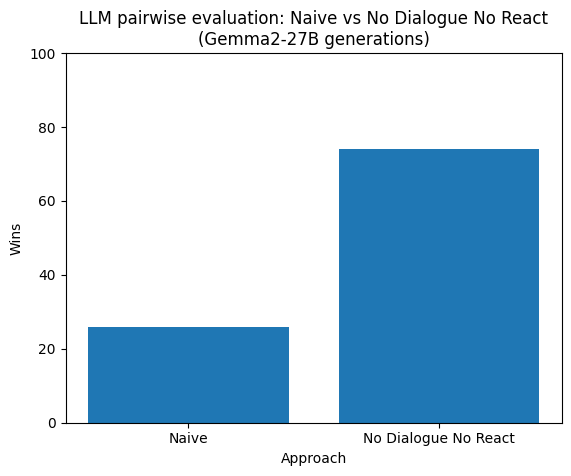

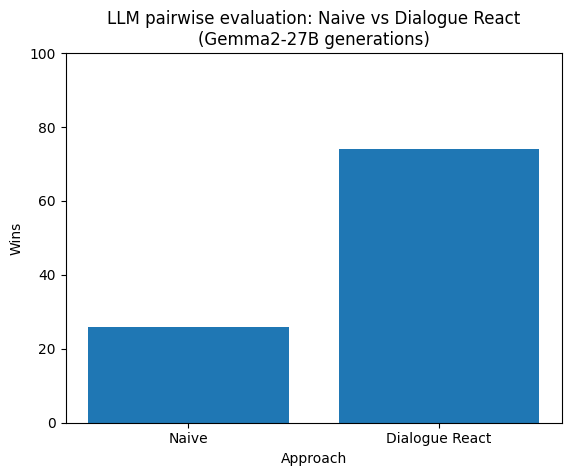

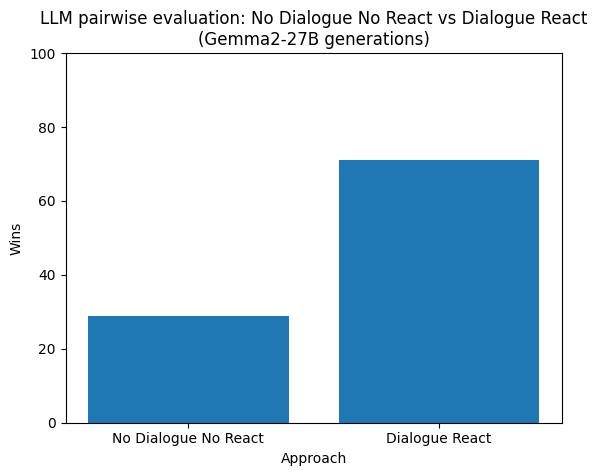

In [35]:
llm_judge_pairwise_matchups=[("naive", "no_dialogue_no_react"), ("naive", "dialogue_react"), ("no_dialogue_no_react", "dialogue_react")]
llm_judge_pairwise= eval_dict["llm_as_judge_pairwise"]
# plot each matchup as a bar chart
import matplotlib.pyplot as plt

for i, match in enumerate(llm_judge_pairwise_matchups):
    # joined name is the name of the two approaches joined by an underscore
    joined_name= "_".join(match)
    # remove underscors in the competitor names
    competitor_a, competitor_b= match
    competitor_a= competitor_a.replace("_", " ")
    competitor_b= competitor_b.replace("_", " ")
    # make the names camel case
    competitor_a= competitor_a.title()
    competitor_b= competitor_b.title()
    
    plt.figure()
    # count instances of A in the vector
    competitor_a_wins= llm_judge_pairwise[joined_name].count("A")
    competitor_b_wins= llm_judge_pairwise[joined_name].count("B")
    plt.ylim(0, 100)
    plt.bar([competitor_a, competitor_b], [competitor_a_wins, competitor_b_wins])
    plt.title(f"LLM pairwise evaluation: {competitor_a} vs {competitor_b}\n(Gemma2-27B generations)")
    plt.ylabel("Wins")
    plt.xlabel("Approach")
    plt.savefig(f"thesis_generations/figures/gemma2_llm_pairwise_{joined_name}.png")
    plt.show()
    

In [36]:
# make ranking of the approaches from the pairwise results

# create a dictionary to store the wincounts of each matchup
matches_results= {}

for match in llm_judge_pairwise_matchups:
    joined_name= "_".join(match)
    competitor_a= match[0]
    competitor_b= match[1]
    # camelcase and no underscores
    competitor_a= competitor_a.title().replace("_", " ")
    competitor_b= competitor_b.title().replace("_", " ")
    
    competitor_a_wins= llm_judge_pairwise[joined_name].count("A")
    competitor_b_wins= llm_judge_pairwise[joined_name].count("B")
    
    matches_results[joined_name]= {competitor_a: competitor_a_wins, competitor_b: competitor_b_wins}
    


In [21]:
# Bradley-Terry model from scratch

# winners and losers table
# each row is an approach, each column is an approach



winners_losers= pandas.DataFrame()

# fill the table with the results

for match in llm_judge_pairwise_matchups:
    joined_name= "_".join(match)
    competitor_a= match[0]
    competitor_b= match[1]
    # camelcase and no underscores
    competitor_a= competitor_a.title().replace("_", " ")
    competitor_b= competitor_b.title().replace("_", " ")
    
    competitor_a_wins= llm_judge_pairwise[joined_name].count("A")
    competitor_b_wins= llm_judge_pairwise[joined_name].count("B")
    
    winners_losers.loc[competitor_a, competitor_b]= competitor_a_wins
    winners_losers.loc[competitor_b, competitor_a]= competitor_b_wins
# sort the columns in the order Naive, No Dialogue No React, Dialogue React
winners_losers= winners_losers.reindex(["Naive", "No Dialogue No React", "Dialogue React"], axis=0)
# sort the rows in the order Naive, No Dialogue No React, Dialogue React
winners_losers= winners_losers.reindex(["Naive", "No Dialogue No React", "Dialogue React"], axis=1)

In [37]:
winners_losers

,Naive,No Dialogue No React,Dialogue React
Naive,NaN,26.0,26.0
No Dialogue No React,74.0,NaN,29.0
Dialogue React,74.0,71.0,NaN


In [38]:
def bradley_terry_iterative(winners_losers, max_iters=100, error_tol=1e-3):
    # initialize the ratings to 1
    ratings= pandas.Series(1, index=winners_losers.index)
    # iterate
    for i in range(max_iters):
        # store the previous ratings
        prev_ratings= ratings.copy()
        # update the ratings
        for approach in ratings.index:
            # get the wins and losses of the approach
            wins= winners_losers.loc[approach].sum()
            losses= winners_losers[approach].sum()
            # update the rating
            ratings[approach]= wins/(wins+losses)
        # check if the ratings have converged
        if (ratings-prev_ratings).abs().max()<error_tol:
            break
    return ratings

In [39]:
ratings= bradley_terry_iterative(winners_losers)

In [40]:
ratings

Naive                   0.260
No Dialogue No React    0.515
Dialogue React          0.725
dtype: float64

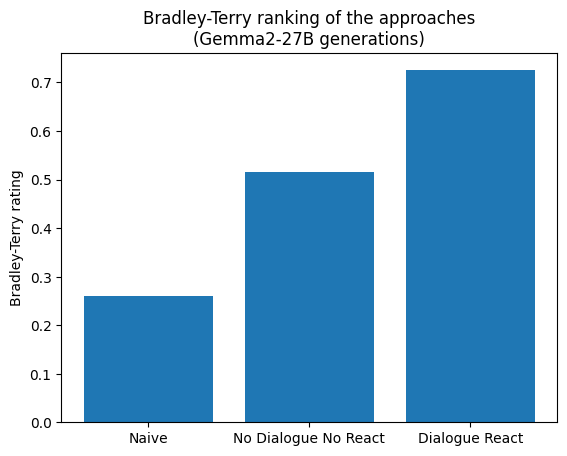

In [30]:
# plot the ratings

plt.figure()
plt.bar(ratings.index, ratings)
plt.ylabel("Bradley-Terry rating")
plt.title("Bradley-Terry ranking of the approaches\n(Gemma2-27B generations)")
plt.savefig("thesis_generations/figures/gemma2_bradley_terry_ratings.png")
plt.show()

## Binomial method

In [41]:
# use binomial test to see if the ratings are significantly different from each other

from scipy import stats
import numpy as np

methods= winners_losers.index.to_list()

alpha = 0.01

significant_wins = {method: 0 for method in methods}

for i in range(len(methods)):
    for j in range(i+1, len(methods)):
        method1 = methods[i]
        method2 = methods[j]
        
        wins_method1 = winners_losers.loc[method1, method2]
        wins_method2 = winners_losers.loc[method2, method1]
        
        if not (np.isnan(wins_method1) or np.isnan(wins_method2)):
            total_comparisons = wins_method1 + wins_method2
            
            # Perform binomial test
            p_value = stats.binom_test(wins_method1, n=total_comparisons, p=1/2)
            
            print(f"Comparison: {method1} vs {method2}")
            print(f"Wins for {method1}: {wins_method1}")
            print(f"Wins for {method2}: {wins_method2}")
            print(f"p-value: {p_value}")
            
            if p_value < alpha:
                print("Significant")
                if wins_method1 > wins_method2:
                    significant_wins[method1] += 1
                else:
                    significant_wins[method2] += 1
            else:
                print("Not significant")
            print()

# Determine the best method
best_method = max(significant_wins, key=significant_wins.get)
print(f"The best method is: {best_method}")
    

Comparison: Naive vs No Dialogue No React
Wins for Naive: 26.0
Wins for No Dialogue No React: 74.0
p-value: 1.6673626494501009e-06
Significant

Comparison: Naive vs Dialogue React
Wins for Naive: 26.0
Wins for Dialogue React: 74.0
p-value: 1.6673626494501009e-06
Significant

Comparison: No Dialogue No React vs Dialogue React
Wins for No Dialogue No React: 29.0
Wins for Dialogue React: 71.0
p-value: 3.2160015295666335e-05
Significant

The best method is: Dialogue React


/tmp/ipykernel_3089759/1644780425.py:24: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = stats.binom_test(wins_method1, n=total_comparisons, p=1/2)


In [42]:
from scipy.stats import chi2_contingency
import numpy as np
from statsmodels.stats.power import GofChisquarePower

# Your contingency table
contingency_table = np.array([
    [15, 85],
    [25, 75],
    [12, 88]
])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Calculate effect size (w)
n = 300 # Total sample size
w = np.sqrt(chi2 / n)

# Perform power analysis
power_analysis = GofChisquarePower()
power = power_analysis.solve_power(effect_size=w, nobs=n, alpha=0.05, n_bins=3)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")
print(f"Effect size (w): {w}")
print(f"Sample size: {n}")
print(f"Statistical power: {power}")

Chi-square statistic: 6.467121588089331
p-value: 0.039416893164689416
Effect size (w): 0.14682326777557353
Sample size: 300
Statistical power: 0.6185429424424659
